In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm

from one_dim_model import *
# one_dim_model is the python script, not the jupyter notebook

In [2]:
# Constants, data, parameters...

rho = 1025 # kg/m^3
c = 4000 # J/(kg C)

dt = 10.0 * 86400 # units: s
dz = 5 # units: m

T_top = 24 # Top temperature
T_bot = 6 # Bottom temperature

z_mix = 50.0 # Depth of minimum mixing layer
z_base = 1000 # Depth of thermocline

# Initial condition, e.g. here we just use a linearly stratified profile

z = np.linspace(0.0, z_base, int(z_base / dz) + 1)
steady = steady_state(z)

In [5]:
# Experimental parameters

years = 50
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

kappa = 5e-6
gamma_year = 1.3
gamma = 1/(gamma_year * 365 * 86400)
mu_year = 100
mu = 1/(mu_year * 365 * 86400)

In [20]:
### Generate parameter space

Qv = np.arange(1.0, 3.0 + 0.2, 0.2)
T0v = np.arange(0.5, 1.0 + 0.01, 0.1)
kappav = np.arange(1e-6, 1e-5 + 1e-7, 1e-6)
gammav = np.arange(0.5, 2.9 + 0.2, 0.2)

num_of_expts = Qv.shape[0] * T0v.shape[0] * kappav.shape[0] * gammav.shape[0]

In [27]:
num_of_expts * 2.8 / 3600

6.673333333333333

### Run the model

In [22]:
%%timeit

# Control 

Q = np.ones(int(years * 360 / days) + 1) * 0.0
T0 = np.ones(int(years * 360 / days) + 1) * 0.0
control = FTCS(dt, dz, kappa, gamma, mu, z_mix, years, steady, Q, T0)

2.71 s ± 7.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit

# Cool

Q = np.ones(int(years * 360 / days) + 1) * - 2.0
T0 = np.ones(int(years * 360 / days) + 1) * - 1.0
cool = FTCS(dt, dz, kappa, gamma, mu, z_mix, years, steady, Q, T0)

2.83 s ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit

# Warm

Q = np.ones(int(years * 360 / days) + 1) * 2.0
T0 = np.ones(int(years * 360 / days) + 1) * 1.0
warm = FTCS(dt, dz, kappa, gamma, mu, z_mix, years, steady, Q, T0)

2.72 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
warm.shape

(200, 1801)

In [51]:
control.itemsize * control.size # size of the warm array in bytes

control.itemsize * control.size * num_of_expts / 1e+9 # size of experiment array in gigabytes... large! should I annually average first?
control.itemsize * 200 * 50 * num_of_expts / 1e+9 # annually average it before storing and you get a muuuuuch smaller array :)

0.6864

### Run lots n lots of experiments!

Below, we run experiments for all combinations of parameters in the (Qv, T0v, kappav, gammav) space as defined above. We will then create a cost function (a (|z| - 1) x |Qv| x |T0v| x |kappav| x |gammav| array) which seeks to minimise the sum of squares of residuals between the experimental curves and the 'truth' curve (where the 'truth' is the output from ACCESS-OM2) for each climate variable (e.g., global average temperature anomaly, SST anomaly).

We will store the output (a (|z| - 1) x |t| array of temperature profiles over time) from each experiment in a large array, $T$, ie 

$$T = \big(T_{ijkl}(z, t)\big),$$ 

where each $T_{ijkl}(z, t)$ contains one experiment corresponding to some unique combination of the $Q_i, T_{0j}, \kappa_k,$ and $\gamma_l$ paramaters.

Using the experiment array, we can globally average and anomalise with respect to the control simulations for each paramater (only $\gamma$ and $\kappa$ influence the control) to get an array of global average temperature anomalies $$\overline{T}' = \big(\overline{T}'_{ijkl}(t)\big).$$ If we denote the global average temperature anomaly from ACCESS $\overline{T}'_{3D}$, then the we define the cost function (a |Qv| x |T0v| x |kappav| x |gammav| array) 

$$C = (c_{ijkl}),$$ 

where 

$$c_{ijkl} = \sum_{n = 1}^{final} \big(\overline{T}'_{3D}(t_n) - \overline{T}'_{ijkl}(t_n)\big)^2.$$ Then, the optimal paramaters will be chosen to be those that correspond to the indicies of

$$\min_{ijkl} C.$$

Then do the same for SST. Then, the optimal

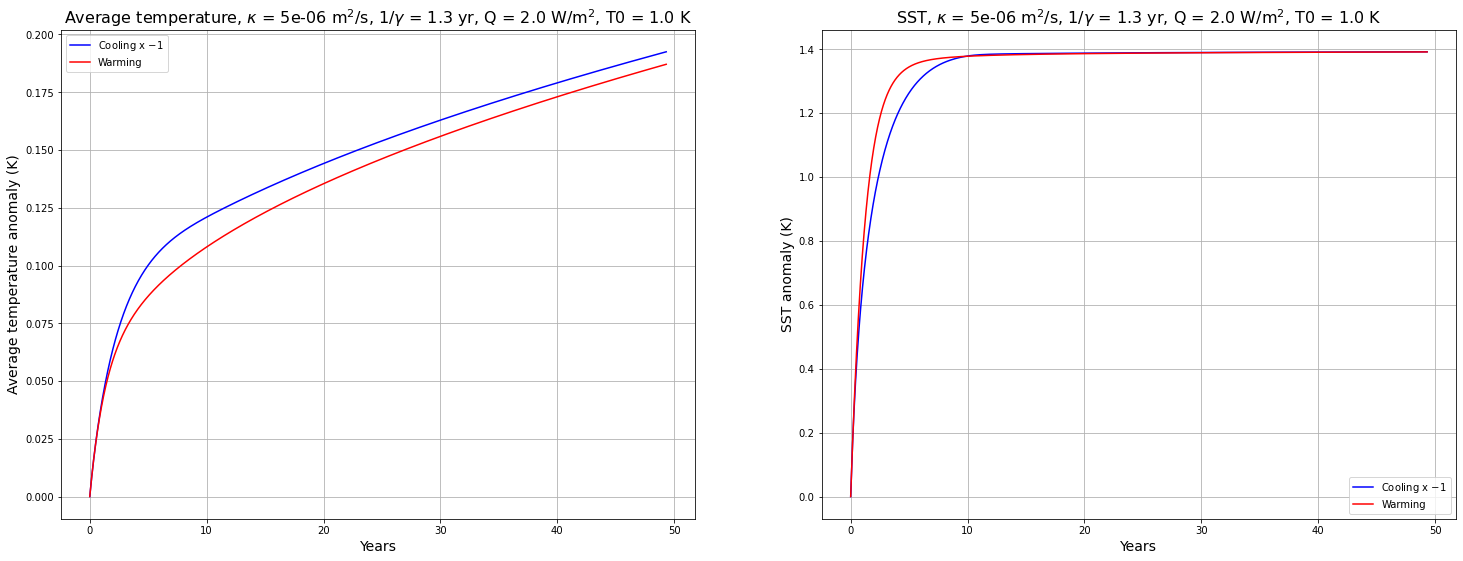

In [19]:
# Plot

days = dt / 86400
timesteps = control.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0, length, timesteps)

#Calculate ocean heat content
GAT_control = OHC(control)
GAT_cool = OHC(cool)
GAT_warm = OHC(warm)
# GAT_coolx2 = OHC(coolx2)
# GAT_warmx2 = OHC(warmx2)
# GAT_coolxhalf = OHC(coolxhalf)
# GAT_warmxhalf = OHC(warmxhalf)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,9))

axs[0].plot(time_years, - 1 * (GAT_cool - GAT_control), color='b', label='Cooling x $-1$')
#axs[0].plot(time_years, - 2 * (GAT_coolxhalf - GAT_control), color='b', label='Half cooling x $-2$', linestyle = '-.')
#axs[0].plot(time_years, - 0.5 * (GAT_coolx2 - GAT_control), color='b', label='Double cooling x $-0.5$', linestyle = '--')
axs[0].plot(time_years, GAT_warm - GAT_control, color='r', label='Warming')
#axs[0].plot(time_years, 2 * (GAT_warmxhalf - GAT_control), color='r', label='Half warming x $2$', linestyle = '-.')
#axs[0].plot(time_years, 0.5 * (GAT_warmx2 - GAT_control), color='r', label='Double warming', linestyle = '--')
#axs[0].plot(time_years, (GAT_warm - GAT_control) + (GAT_cool - GAT_control))
axs[0].grid()
axs[0].set_title('Average temperature, $\kappa$ = {} m$^2$/s, $1/\gamma$ = {} yr, Q = {} W/m$^2$, T0 = {} K'.format(kappa, gamma_year, Q[0], T0[0]), fontsize = 16)
axs[0].set_ylabel('Average temperature anomaly (K)', fontsize = 14)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].legend()

axs[1].plot(time_years,  - 1 * (cool[0, :] - control[0, :]), color='b', label='Cooling x $-1$')
#axs[1].plot(time_years,  - 2 * (coolxhalf[0, :] - control[0, :]), color='b', label='Half cooling x $-2$', linestyle = '-.')
#axs[1].plot(time_years,  - 0.5 * (coolx2[0, :] - control[0, :]), color='b', label='Double cooling x $-0.5$', linestyle = '--')
axs[1].plot(time_years, warm[0, :] - control[0, :], color='r',label='Warming')
#axs[1].plot(time_years,  2 * (warmxhalf[0, :] - control[0, :]), color='r', label='Double warming x $2$', linestyle = '-.')
#axs[1].plot(time_years, 0.5 * (warmx2[0, :] - control[0, :]), color='r',label='Double warming x $0.5', linestyle = '--')
#axs[1].plot(time_years, (warm_expt[0, :] - control_expt[0, :]) + (cool_expt[0, :] - control_expt[0, :]))
axs[1].grid()
axs[1].set_title('SST, $\kappa$ = {} m$^2$/s, $1/\gamma$ = {} yr, Q = {} W/m$^2$, T0 = {} K'.format(kappa, gamma_year, Q[0], T0[0]), fontsize = 16)
axs[1].set_ylabel('SST anomaly (K)', fontsize = 14)
axs[1].set_xlabel('Years',fontsize = 14)
axs[1].legend()
#plt.savefig('SST and OHC anomalies, single abrupt, kappa = {}, Q = {}, gamma = {}.jpg'.format(kappa, Q, gamma_year))